# Ensemble: siconc

## Imports & defaults

In [1]:
import libs.analysis
import libs.plot
import libs.vars
import matplotlib
import numpy as np
import xarray

matplotlib.rcParams.update({ 'font.size': 18 })

## Data

In [2]:
ensemble = libs.vars.ensemble()

experiment = 'ssp585'
path_base = '_data/cmip6/{source_id}/{variable_id}/'
areacello_pattern = '{variable_id}_Ofx_{source_id}_piControl_{areacello_variant}_gn.nc'
var_pattern = '{variable_id}_SImon_{source_id}_{experiment}_{variant_label}_gn_201501-210012_processed.nc'

area_units = 'km²'
siconc_units = '%'
variable_id = 'siconc'
variable_text = 'sea-ice area'
y_label = f'Area ({area_units})'

colormesh_kwargs = {
    'extend': 'neither',
    'levels': 11,
    'vmin': 0,
    'vmax': 100,
    'x': 'longitude', 
    'y': 'latitude',
    'shading': 'gouraud'
}

# Since variables have been regridded, can use UKESM areacello
# for all ensemble member weighted means/sums
areacello_path = f'{path_base}{areacello_pattern}'.format(
    source_id='UKESM1-0-LL', 
    areacello_variant='r1i1p1f2',
    variable_id='areacello'
)
weight = xarray.open_mfdataset(
    paths=areacello_path,
    combine='by_coords',
    autoclose=True
).areacello.fillna(0)

# Get nsidc region mask, which has been regridded to UKESM ocean grid
path_nsidc_mask = '_data/_cache/NSIDC_Regions_Masks_Ocean_nearest_s2d.nc'
nsidc_mask = xarray.open_mfdataset(paths=path_nsidc_mask, combine='by_coords').mask
nsidc_regions = [
    r for r in libs.vars.nsidc_regions() if r['label'] == 'All'
][0]

for i, item in enumerate(ensemble):
    source_id = item['source_id']
    variant_label = item['variant_label']

    var_path = f'{path_base}{var_pattern}'.format(
        experiment=experiment,
        source_id=source_id, 
        variant_label=variant_label,
        variable_id=variable_id
    )
    
    data = xarray.open_mfdataset(
        paths=var_path,
        combine='by_coords',
        autoclose=True,
        use_cftime=True
    )
    
    # Mask data to arctic + nsidc regions
    data[variable_id] = data[variable_id]\
        .where(data[variable_id].latitude > 60)\
        .where(np.isin(nsidc_mask.values, nsidc_regions['values']))\
    
    ensemble[i]['data'] = data[variable_id]
    ensemble[i]['label'] = data.attrs['source_id']


si_arr_weighted_sum = []
si_arr_weighted_sum_sep_mar = []
si_arr_weighted_sum_smooth = []
for item in ensemble:
     # Convert from m2 to km2 and % to fraction
    item_data = item['data'] / (1000 * 1000 * 100)
    si_weighted = item_data.weighted(weight)
    si_weighted_sum = si_weighted.sum(dim=si_weighted.weights.dims, skipna=True)

    si_arr_weighted_sum.append({
        'color': item['color'],
        'data': si_weighted_sum,
        'label': item['label']
    })
    si_arr_weighted_sum_smooth.append({
        'color': item['color'],
        'data': libs.analysis.smoothed_mean(si_weighted_sum),
        'label': item['label']
    })
    
    si_weighted_sep = item_data\
        .where(item_data.time['time.month'] == 9, drop=True)\
        .weighted(weight)\
        .sum(dim=si_weighted.weights.dims, skipna=True)
        
    si_weighted_mar = item_data\
        .where(item_data.time['time.month'] == 3, drop=True)\
        .weighted(weight)\
        .sum(dim=si_weighted.weights.dims, skipna=True)\

    si_arr_weighted_sum_sep_mar.append({
        'color': item['color'],
        'data': si_weighted_sep,
        'label': item['label'],
        'plot_kwargs': { 'linestyle': 'dashed' },
    })
    si_arr_weighted_sum_sep_mar.append({
       'color': item['color'],
       'data': si_weighted_mar,
       'label': item['label']
    })

si_arr_weighted_sum_smooth.append(
    libs.analysis.ensemble_mean(si_arr_weighted_sum_smooth)
)

# Generate slices
ensemble_time_slices = libs.analysis.generate_slices(ensemble)

## Time series

### Mean

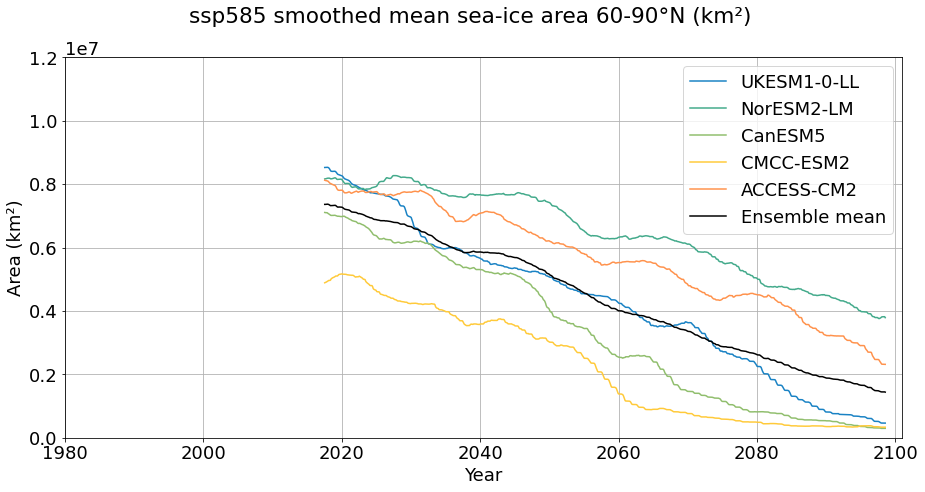

In [3]:
libs.plot.time_series(
    si_arr_weighted_sum_smooth,
    title=f'{experiment} smoothed mean {variable_text} 60-90°N ({area_units})',
    xattr='time',
    ylabel=y_label,
    yrange=(0, 1.2e7)
)

### September (min) & March (max)

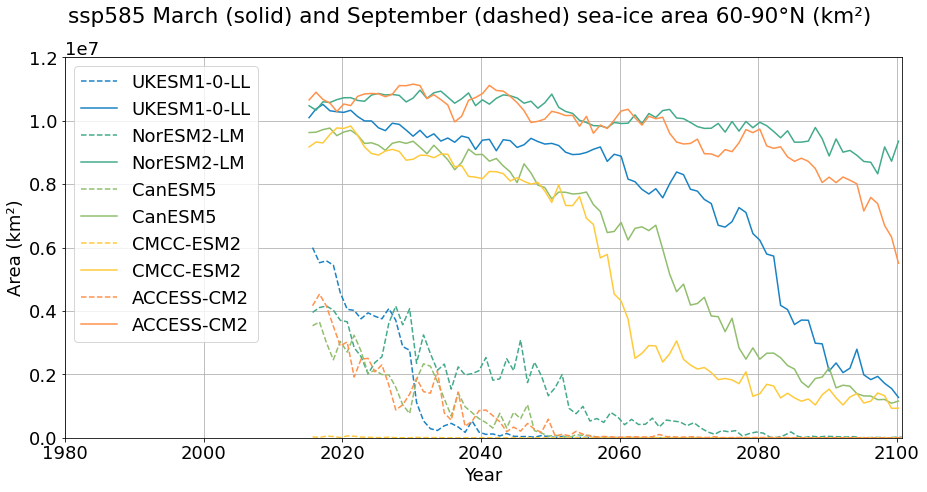

In [4]:
libs.plot.time_series(
    si_arr_weighted_sum_sep_mar,
    title=f'{experiment} March (solid) and September (dashed) {variable_text} 60-90°N ({area_units})',
    xattr='time',
    ylabel=y_label,
    yrange=(0, 1.2e7)
)

### Full variability

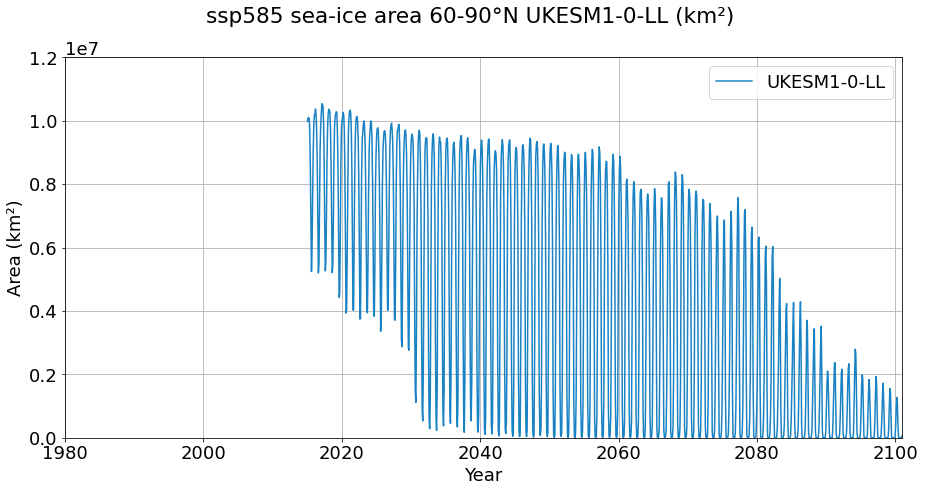

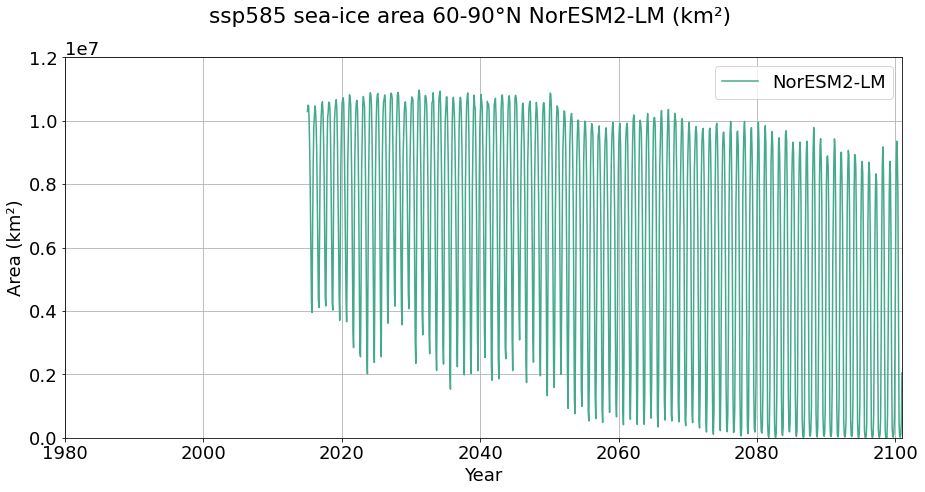

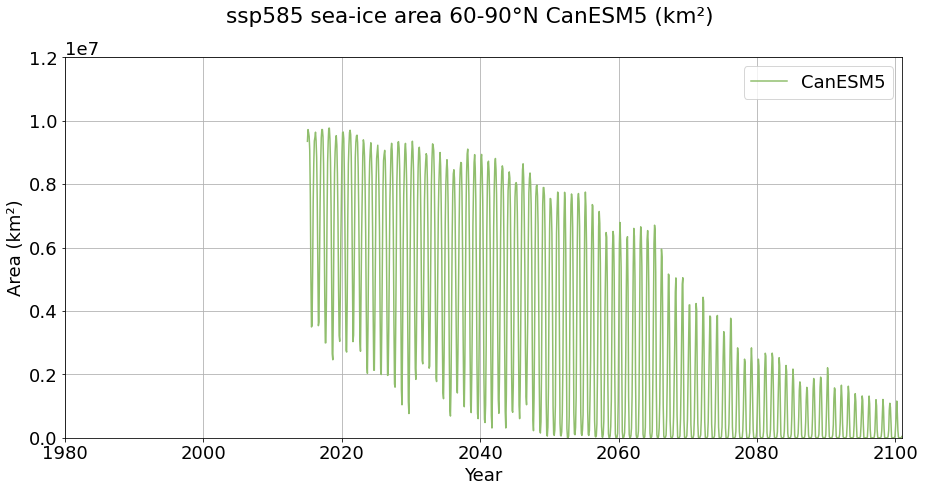

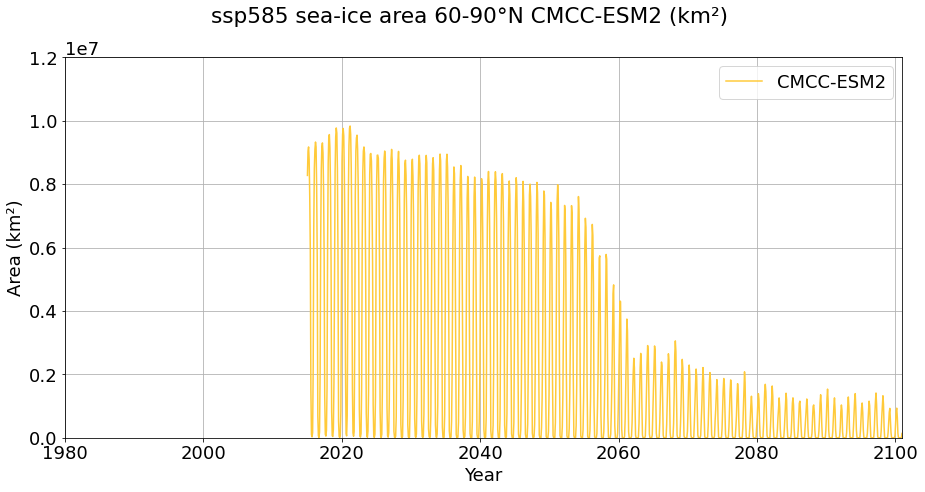

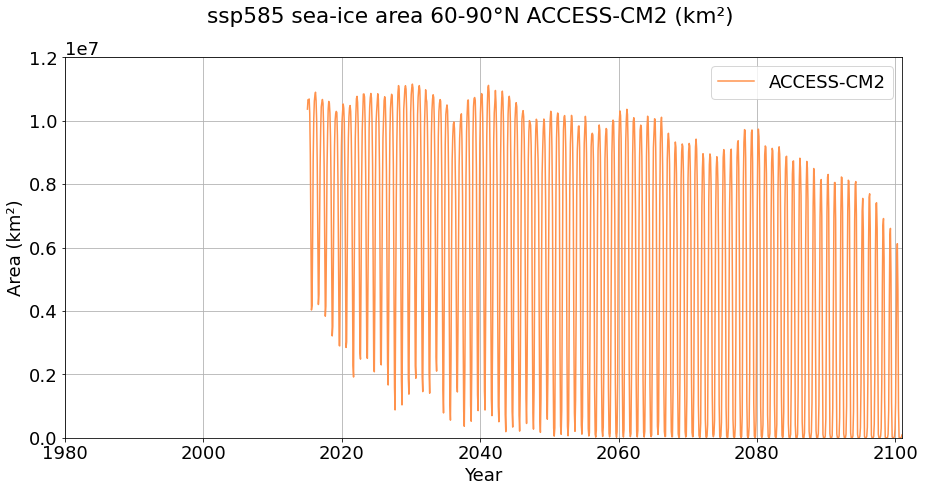

In [5]:
for item in si_arr_weighted_sum:
    member = item['label']

    libs.plot.time_series(
        [item],
        title=f'{experiment} {variable_text} 60-90°N {member} ({area_units})',
        xattr='time',
        ylabel=y_label,
        yrange=(0, 1.2e7)
    )

## Monthly variability

### Full region (time)

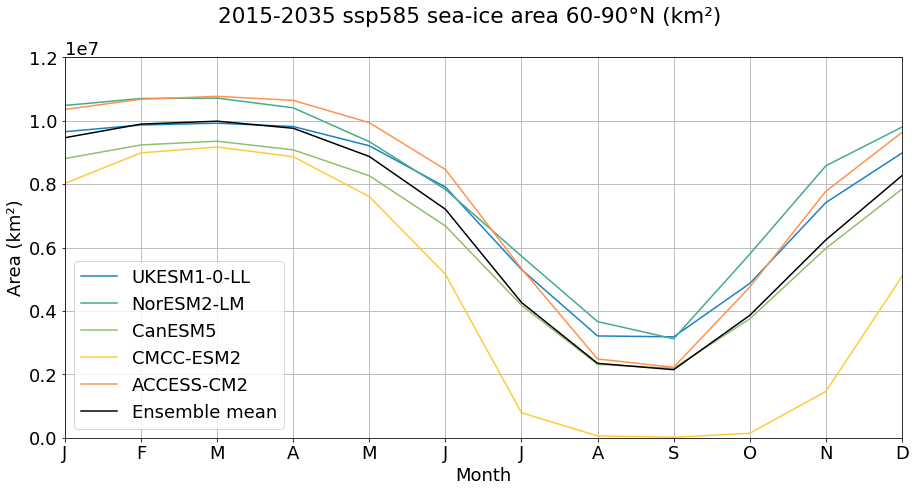

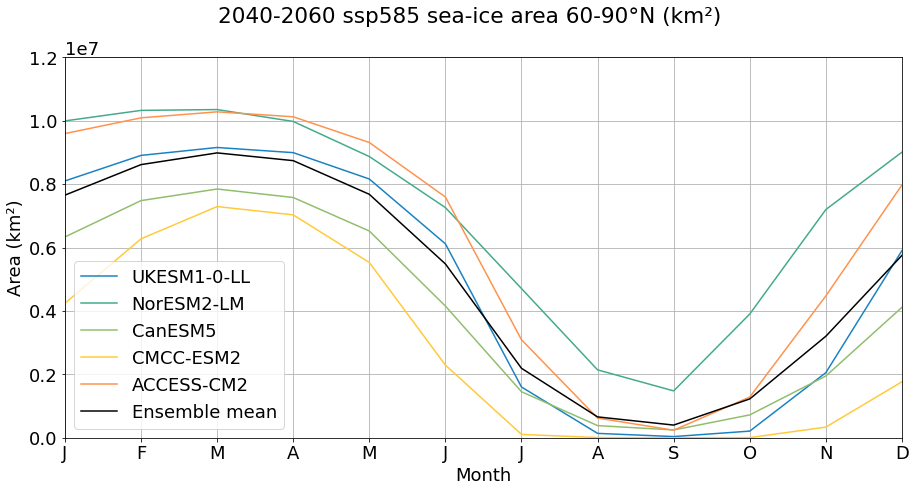

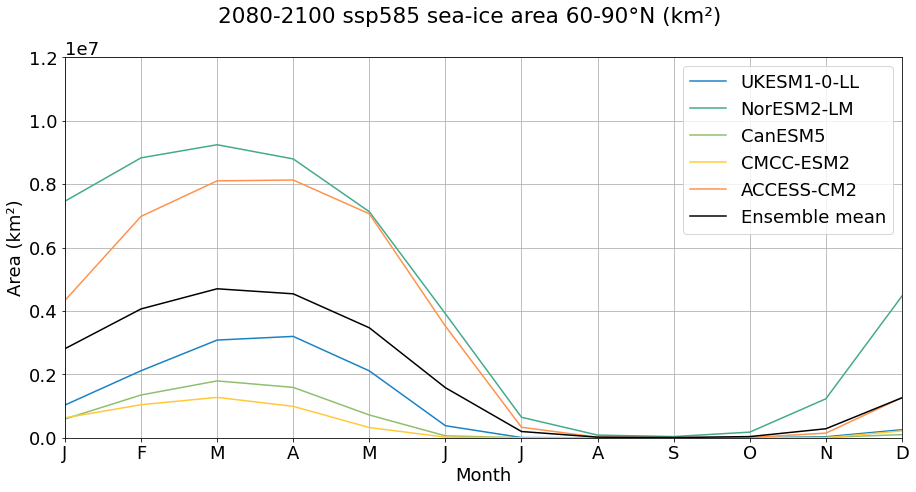

In [6]:
for s in ensemble_time_slices:
    ensemble_processed = [{ 
        'color': item['color'],
        'data': libs.analysis.monthly_weighted(
            item['data'] / (1000 * 1000 * 100), 
            weight,
            method='sum'
        ),
        'label': item['label']
    } for item in s['ensemble']]
    
    # Calculate and add ensemble mean
    ensemble_processed.append(libs.analysis.ensemble_mean(ensemble_processed))
    
    s_label = s['label']

    libs.plot.monthly_variability(
        ensemble_processed,
        title=f'{s_label} {experiment} {variable_text} 60-90°N ({area_units})',
        ylabel=y_label,
        yrange=(0, 1.2e7)
    )

### Regional sea-ice area (time)

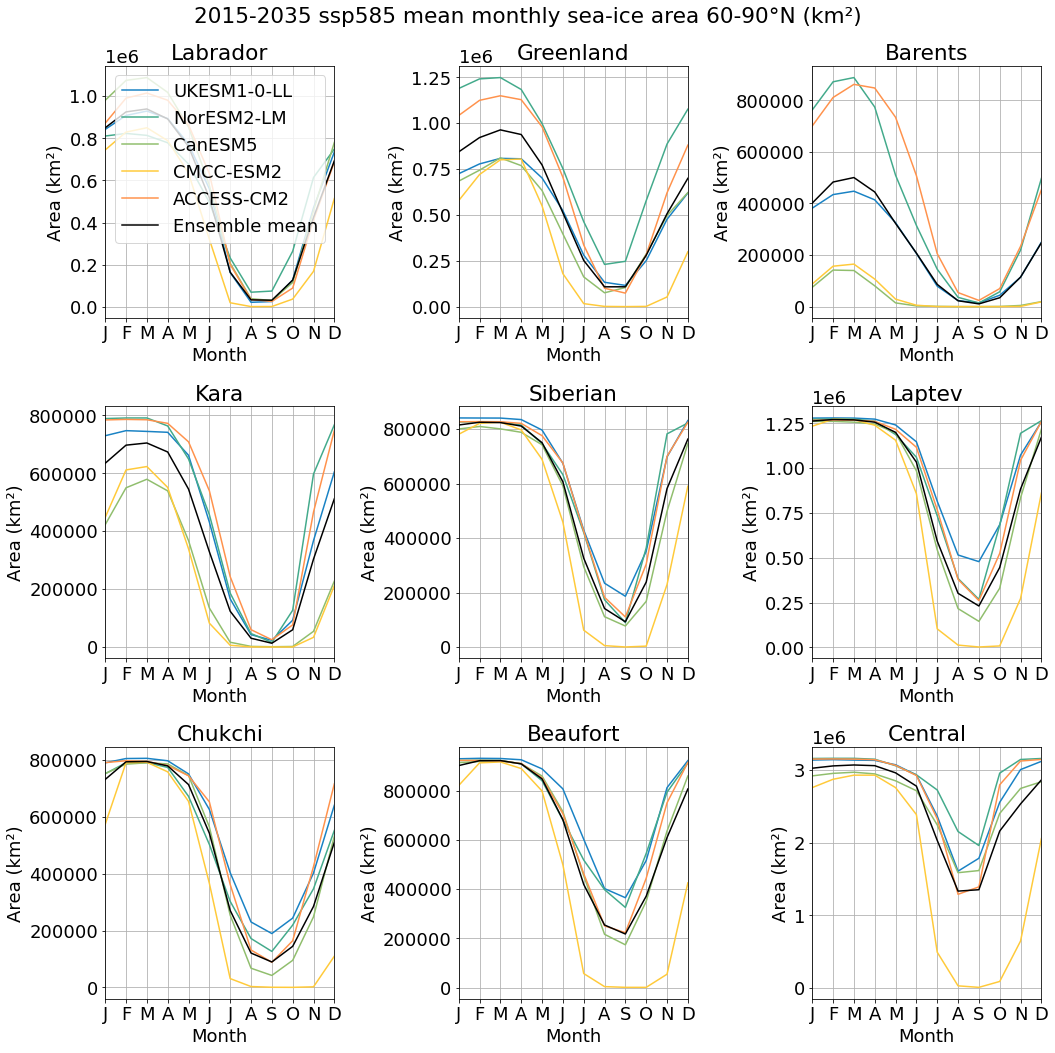

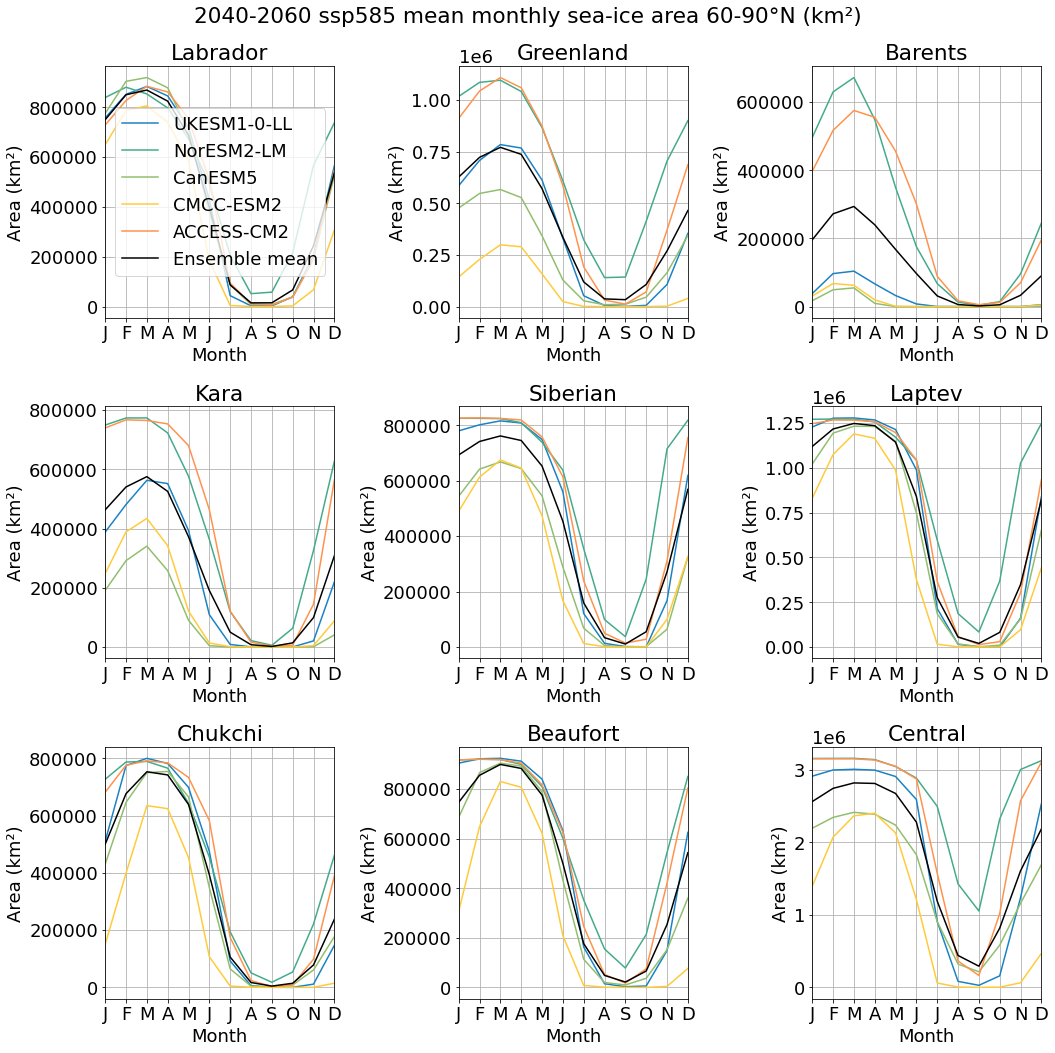

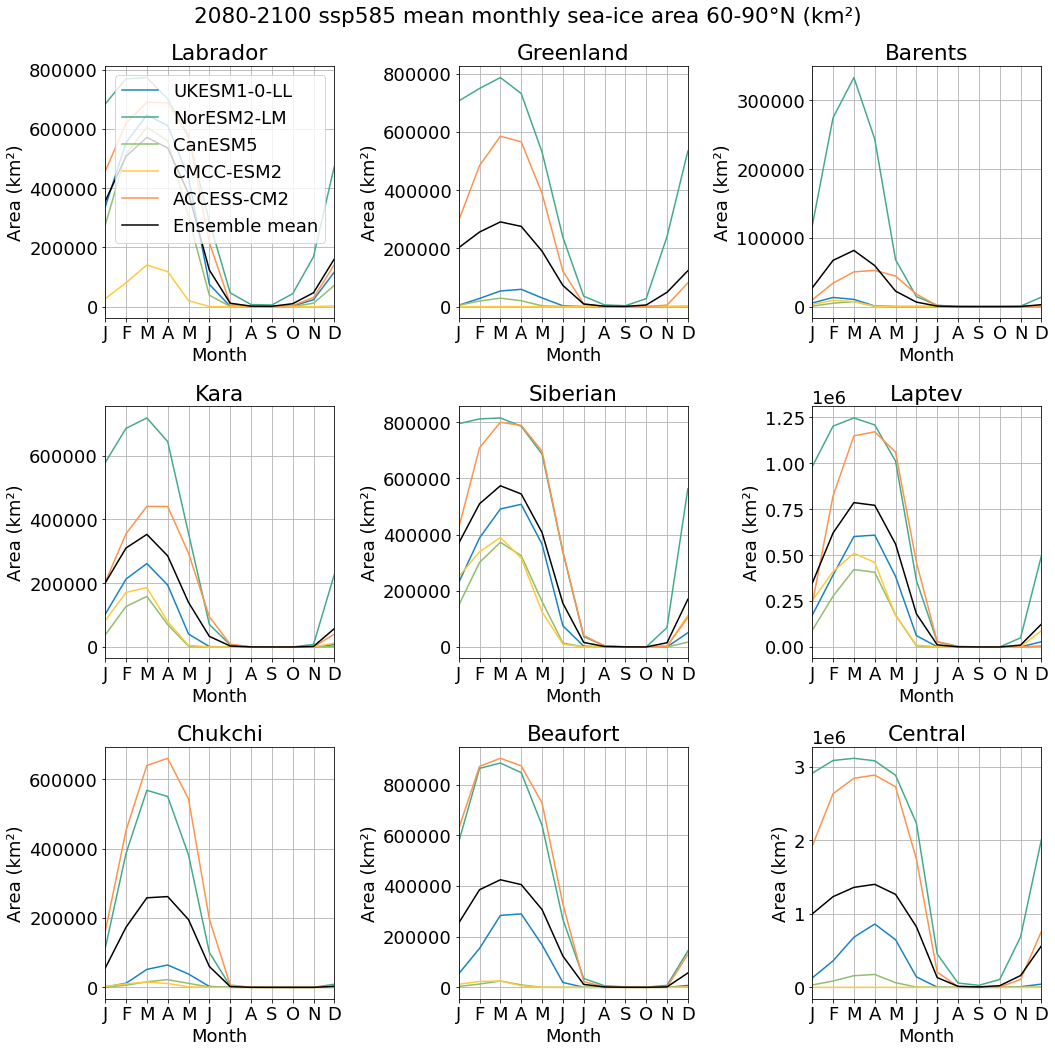

In [7]:
for s in ensemble_time_slices:
    s_label = s['label']

    libs.plot.monthly_variability_regional(
        s['ensemble'], 
        title=f'{s_label} {experiment} mean monthly {variable_text} 60-90°N ({area_units})',
        ylabel=y_label,
        mask_type='ocean',
        calc_ensemble_mean=True,
        process=lambda x: libs.analysis.monthly_weighted(
            x / (1000 * 1000 * 100), 
            weight,
            method='sum'
        )
    )

### Full region March maximum (spatial)

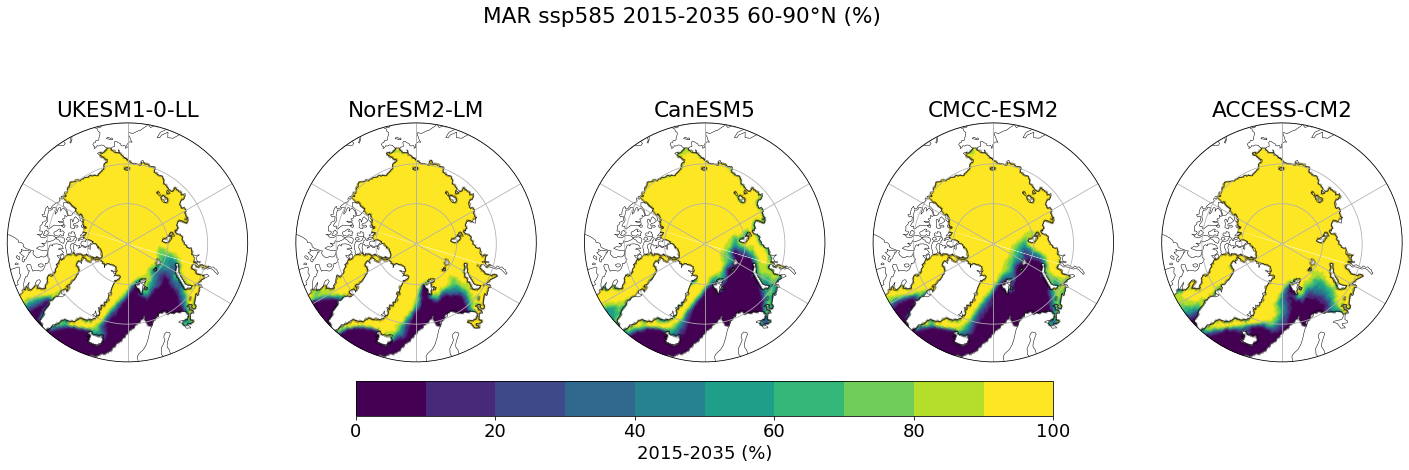

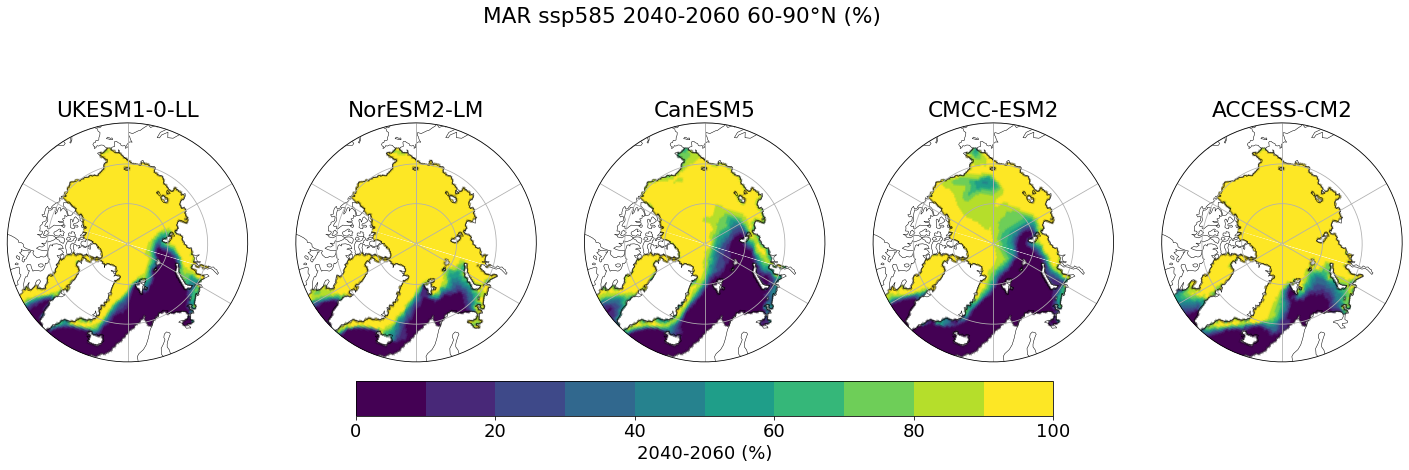

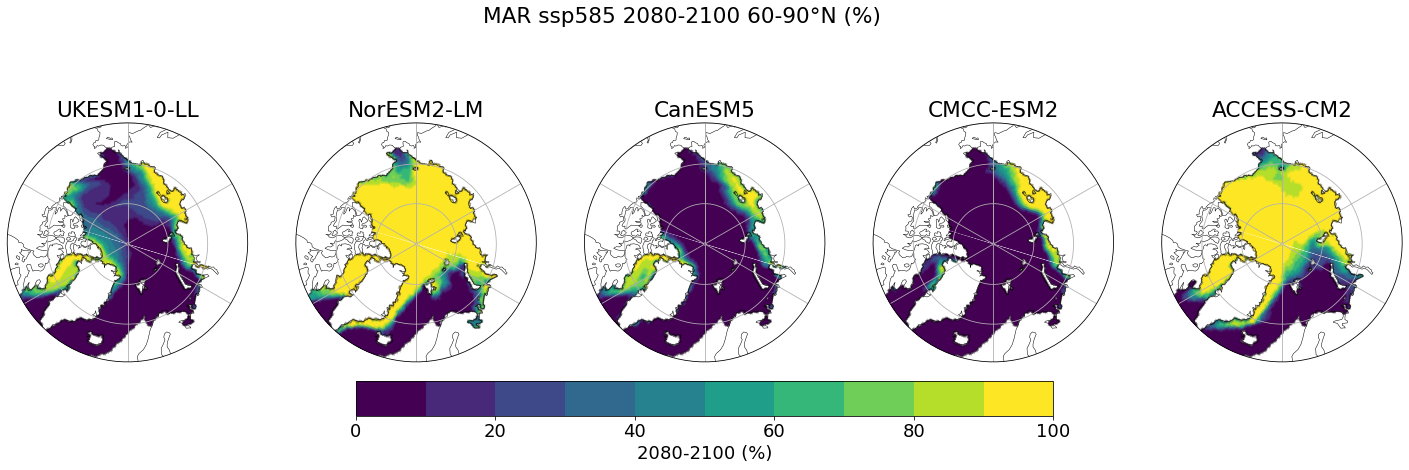

In [8]:
libs.plot.monthly_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    months=['MAR'],
    title='{m} ssp585 {label} 60-90°N ({units})',
    units=siconc_units
)

### Full region September minimum (spatial)

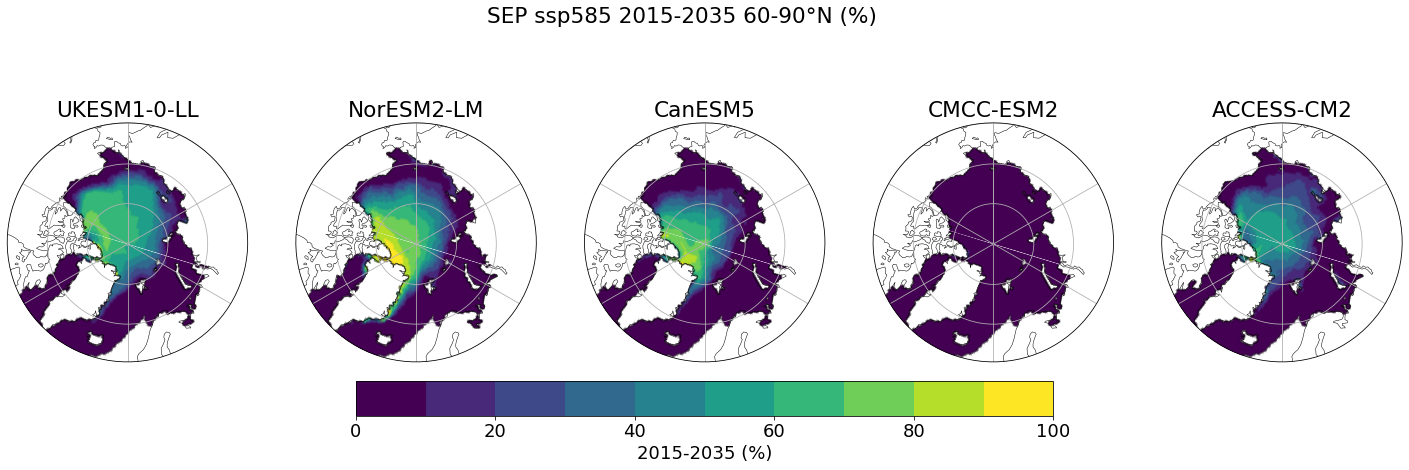

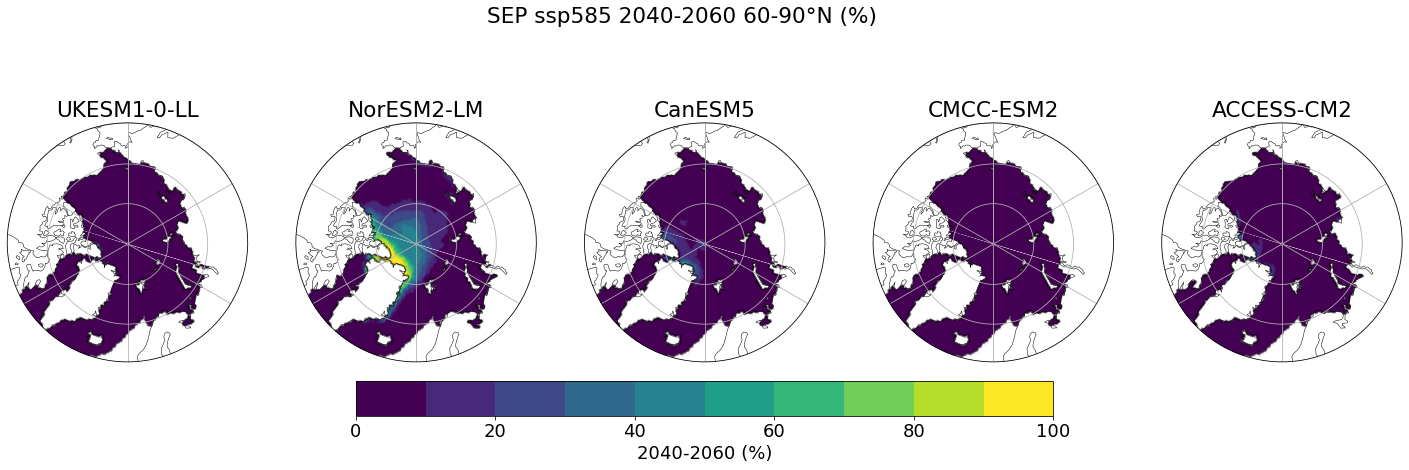

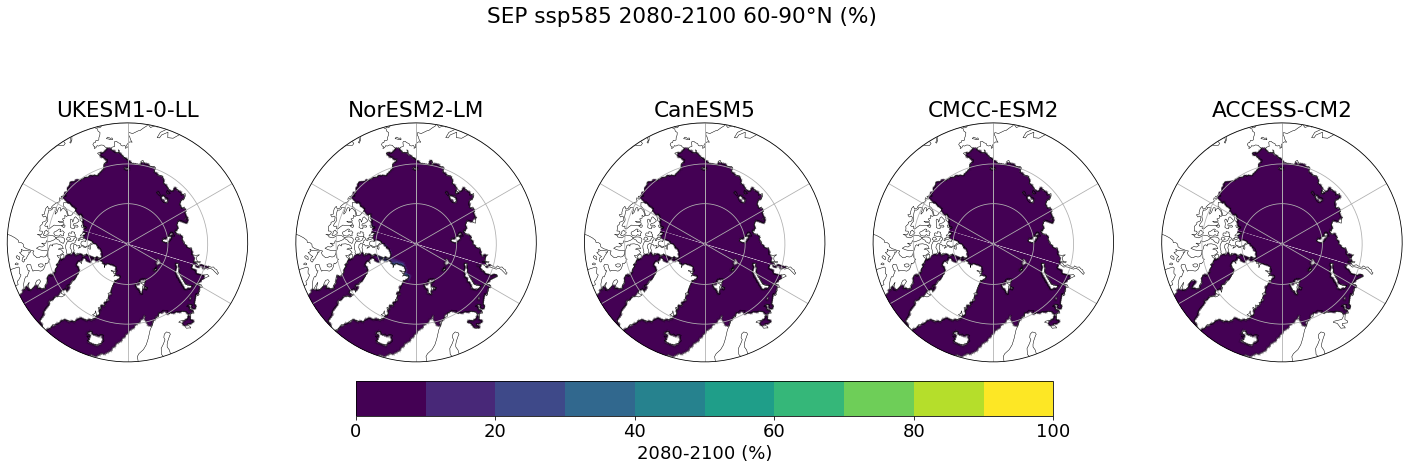

In [9]:
libs.plot.monthly_spatial(
    ensemble_time_slices, 
    colormesh_kwargs=colormesh_kwargs,
    months=['SEP'],
    title='{m} ssp585 {label} 60-90°N ({units})',
    units=siconc_units
)